# LLG with correlation
The local bidders $1$ and $2$ are both only interested in one item, whereas the global bidder $3$ only values the bundle of both items. We again set $\Omega = \mathcal{U}(0,1)^5$ and let $v_3 = \omega_3$ be the valuation of the global bidder and
$$
v_1(\omega) = w \omega_4 + (1-w)\omega_1, \quad v_2(\omega) = w \omega_4 + (1-w)\omega_2, 
$$
be the valuations of the local bidders.
## (a) Bernoulli weights model
$$
	w(\omega) = \begin{cases}
		1 & \text{if } \omega_5 < \gamma, \\
		0 & \text{else}.
	\end{cases}
$$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Joint PDF of locals 

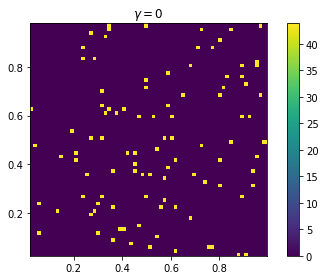

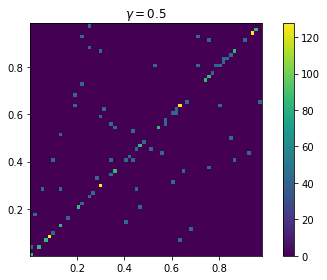

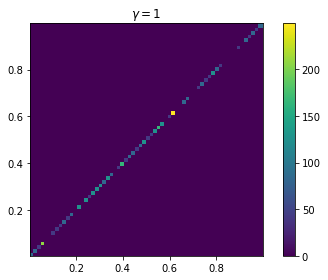

In [7]:
for gamma in [0, 0.5, 1]:

    # draw samples
    n_samples = 100
    u = torch.zeros((n_samples, 4)).uniform_(0, 1)
    mask = u[:, 2] < gamma
    v1 = mask * u[:, 3] + torch.logical_not(mask) * u[:, 0]
    v2 = mask * u[:, 3] + torch.logical_not(mask) * u[:, 1]

    # plot
    ax = plt.gca()
    plt.hist2d(v1.numpy(), v2.numpy(), bins=64, density=True)
    ax.set_aspect('equal', 'box')
    plt.colorbar(ax=ax)
    plt.title('$\gamma = {}$'.format(gamma))
    plt.tight_layout()
    plt.show()

In [14]:
def cond_icdf(cond, gamma):
    def icdf(n_samples):
        result = torch.zeros((n_samples, 1)).uniform_(0, 1)
        switch = torch.zeros((n_samples, 1)).uniform_(0, 1) > gamma
        result = switch * result + torch.logical_not(switch) * cond * torch.ones_like(result)
        return result
    return icdf
icdf = cond_icdf(torch.tensor(.2), .1)(10000).numpy()

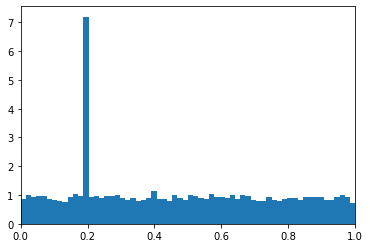

In [15]:
plt.hist(icdf, density=True, bins=64)
plt.xlim(0, 1)
plt.show()

## (b) Constant weights model
$$
	w(\omega) = \begin{cases}
		\frac{\gamma-\sqrt{\gamma(1-\gamma)}}{2\gamma-1} & \text{if } \gamma \neq 1/2, \\
		1/2 & \text{else}.
	\end{cases}
$$

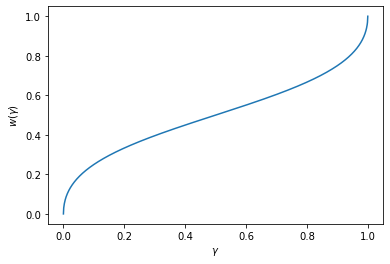

In [198]:
gamma = np.linspace(0, 1, 1000)
w = (gamma - np.sqrt(gamma*(1-gamma))) / (2*gamma - 1)

plt.plot(gamma, w)
plt.xlabel('$\gamma$'); plt.ylabel('$w(\gamma)$')
plt.show()

---
# Light weight apporach

We have

$$v_1 = (1-w)z_1 + ws$$
$$v_2 = (1-w)z_2 + ws$$

and thus

$$ v_2 = (1-w)(z_2 - z_1) + v_1 $$ and the conditional

$$v_2|v_1 = (1-w)(z_2|v_1 - z_1|v_1) + v_1$$ but $z_2$ is (conditionally) independent from $v_1$.

To sample $v_2|v_1$ we thus only need the distribution of $z_1|v_1$. To find this, we can use Bayes thm and get

$$
f_{Z_1|V_1=v_1}(z_1) \propto f_{V_1|Z_1}(v_1)f_{Z_1}(z_1) = f_{V_1|Z_1}(v_1) \mathbb{1}_{[0,1]}(z_1)
$$

We have
$$Z_1 = \frac{V_1 - wS}{1-w} $$

and, as $Z_1 \perp S$, the value of $V_1|Z_1$ is determined by the possible value of the uniformly distributed $S$ and we get
$$f_{V_1|Z_1=z_1}(v_1) = \begin{cases} 0 & v_1 < (1-w)z_1 \\ \frac{1}{w} & (1-w)z_1 < v_1 < (1-w)z_1 + w \\ 0 & v_1 > (1-w)z_1 + w\end{cases}$$

i.e. $$V_1|Z_1 \sim \mathcal U[(1-w)z_1 , (1-w)z_1 + w]$$

Rewriting the boundaried in terms of $z_1$ for the left hand side of the Bayesian equation, we further have

$$Z_1|V_1=v_1 \sim \mathcal U\left[\frac{v_1-w}{1-w} , \frac{v_1}{1-w}\right]$$

Possibly, we need to cap this at $[0,1]$ (correponds to indicator in $f_{Z_1}$ above.)

For $w=1$, i.e. $\gamma=1$, we have $V_1 = V_2$, thus the value of $Z_2 - Z_1$ doesn't matter and can be disregarded.

Empirical Validation

In [2]:
def weight(gamma):
    if gamma==0.5:
        return 0.5
    return (gamma - np.sqrt(gamma*(1-gamma))) / (2*gamma - 1)

def d_v1_given_z1(gamma, z1):
    w = weight(gamma)
    return torch.distributions.Uniform((z1 *(1-w)), z1*(1-w) + w)


# given z1 and v1 are both std-uniform, we get by Bayes theorem:
def d_z1_given_v1(gamma,v1):
    # degenerate case -- z1 doesn't matter, but we still need the interface
    if gamma==1.0:
        return torch.distributions.Uniform(0,1)
    
    w= weight(gamma)
    return torch.distributions.Uniform(max(0,(v1 - w)/(1-w)), min(1,v1/(1-w)))

def draw_conditional_v2(n, gamma, v1):
    w = weight(gamma)
    # z1 is conditionally independent from v1
    z2 = dz2.sample((n,))
    conditional_dist_z1 = d_z1_given_v1(gamma, v1)
    z1 = conditional_dist_z1.sample((n,))
    v2 = (1-w)*(z2 - z1) + v1
    return v2  

def draw_joint_observations(n,gamma):
    w = weight(gamma)
    z1 = dz1.sample((n,))
    z2 = dz2.sample((n,))
    s = ds.sample((n,))

    v1 = (1-w)*z1 + w*s
    v2 = (1-w)*z2 + w*s
    
    return v1,v2
  
def conditional_slice(v1, v2, v1_value, delta=0.01):
    "return all v2 with matching v1 in v1_value +- delta"
    indices = torch.logical_and(v1 > v1_value - delta, v1 < v1_value + delta)
    return v2[indices]

Plot Histograms of slice-of joined vs sampled from conditional for all $\gamma$, $v_1$

In [3]:
# all histograms
n_samples_joint = 1000000
n_samples_cond = int(n_samples_joint/1000)

n_gammas = 4
n_v1_vals = 4
gammas = [i/n_gammas for i in range(n_gammas+1)]
v1_vals = [i/n_v1_vals for i in range(n_v1_vals+1)]

bins = np.linspace(0, 1, 50)

fig, axs = plt.subplots(
    nrows=n_v1_vals+1, ncols=n_gammas+1,
    sharex=True, sharey=False,
    figsize=(12, 12)
)

for col, gamma in enumerate(gammas):
    v1, v2 = draw_joint_observations(n_samples_joint,gamma)
    
    for row, v1_val in enumerate(v1_vals):
        ax = axs[row, col]
        
        v2_slice = conditional_slice(v1,v2, v1_val)
        v2_cond = draw_conditional_v2(n_samples_cond, gamma, v1_val)
        
        ax.hist(v2_slice.numpy(), bins, alpha=0.4, label='slice of joint',density=True)
        ax.hist(v2_cond.numpy(), bins, alpha=0.4, label='conditional sample', density=True)
        ax.legend([], loc='lower left', title=f'$\gamma = {gamma:.1f}$, $v_1 = {v1_val:.3f}$')
    
        
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

---
# Deprecated: Conditional Sampling

### Joint PDF of locals

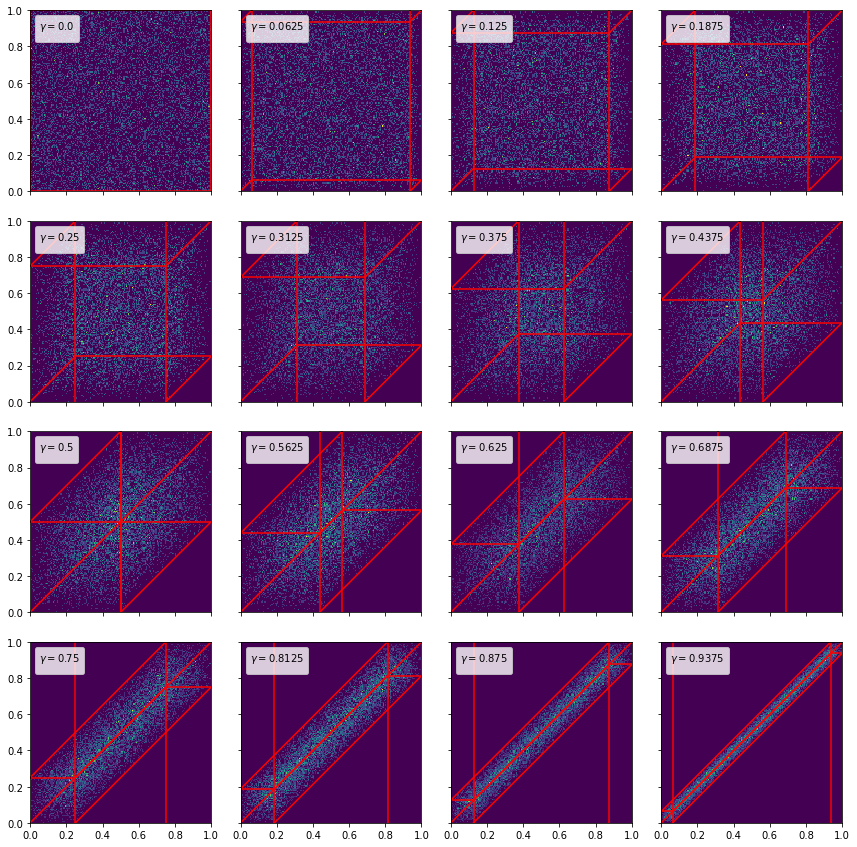

In [219]:
gammas = [x/16 for x in range(16)]
fig, axs = plt.subplots(
    nrows=int(len(gammas)**.5), ncols=int(len(gammas)**.5),
    sharex=True, sharey=True,
    figsize=(12, 12)
)
n_samples = 10000
u = torch.zeros((n_samples, 4)).uniform_(0, 1)

i = 0
j = 0
for gamma in gammas:
    ax = axs[i, j]

    # draw samples
    v1 = gamma * u[:, 3] + (1 - gamma) * u[:, 0]
    v2 = gamma * u[:, 3] + (1 - gamma) * u[:, 1]

    # plot
    ax.hist2d(v1.numpy(), v2.numpy(), bins=164, density=True)
    ax.set_aspect('equal', 'box')
    ax.plot([0, gamma], [0, gamma], color='red')
    ax.plot([1-gamma, 1], [0, gamma], color='red')
    ax.plot([gamma, 1], [gamma, gamma], color='red')
    ax.plot([0, gamma], [1-gamma, 1], color='red')
    ax.plot([0, 1-gamma], [1-gamma, 1-gamma], color='red')
    ax.plot([1-gamma, 1], [1-gamma, 1], color='red')
    ax.plot([gamma, gamma], [0, 1], color='red')
    ax.plot([1-gamma, 1-gamma], [0, 1], color='red')
    ax.set_xlim([0, 1.]); ax.set_ylim([0, 1])
    ax.legend([], loc='upper left', title='$\gamma = {}$'.format(gamma))
    
    if j < int(len(gammas)**.5) - 1:
        j += 1
    else:
        i += 1
        j = 0

plt.tight_layout()
plt.show()

In [3]:
def pdf_v2_cond_v1(gamma, v1):
    """Conditional PDF of observation 2 given observation 1"""
    switch = gamma < 0.5
    [mini, maxi] = sorted((gamma, 1 - gamma))

    if v1 < mini:
        def pdf(v2):
            result = torch.zeros_like(v2)

            increase_mask = v2 < v1
            result[increase_mask] = v2[increase_mask]

            constant_mask = torch.logical_and(v2 >= v1, v2 < 1-gamma)
            result[constant_mask] = v1

            decrease_mask = torch.logical_and(v2 >= 1-gamma, v2 < (1-gamma) + v1)
            result[decrease_mask] = 1 - gamma + v1 - v2[decrease_mask]
            
            h = v1
            l = 1-gamma - v1 + h
            result /= h*l

            return result


    elif v1 > maxi:
        def pdf(v2):
            result = torch.zeros_like(v2)

            increase_mask = torch.logical_and(v2 > (gamma-1) + v1, v2 < gamma)
            result[increase_mask] = v2[increase_mask] - (gamma-1) - v1 

            constant_mask = torch.logical_and(v2 >= gamma, v2 < v1)
            result[constant_mask] = 1 - v1

            decrease_mask = v2 >= v1
            result[decrease_mask] = 1 - v2[decrease_mask]
            
            h = 1 - v1
            l = v1 - gamma + h
            result /= h*l

            return result

    else:
        def pdf(v2):
            result = torch.zeros_like(v2)
            
            if switch:
                increase_mask = v2 < mini
                result[increase_mask] = v2[increase_mask]

                constant_mask = torch.logical_and(v2 >= mini, v2 < maxi)
                result[constant_mask] = 1 - maxi

                decrease_mask = v2 >= maxi
                result[decrease_mask] = 1 - v2[decrease_mask]
            
                h = 1 - maxi
                l = maxi - mini + h
                result /= h*l

            else:
                increase_mask = torch.logical_and(v2 >= (gamma-1) + v1, v2 < v1)
                result[increase_mask] = v2[increase_mask] - v1 + (1-gamma)

                decrease_mask = torch.logical_and(v2 >= v1, v2 < (1-gamma) + v1)
                result[decrease_mask] = v1 + (1-gamma) - v2[decrease_mask]

                result /= (1-gamma)**2

            return result
        
    return pdf

In [4]:
def cdf_v2_cond_v1(gamma, v1):
    """Conditional CDF of observation 2 given observation 1"""
    switch = gamma < 0.5
    [mini, maxi] = sorted((gamma, 1 - gamma))

    if v1 < mini:
        def cdf(v2):
            result = torch.zeros_like(v2)

            increase_mask = v2 < v1
            result[increase_mask] = 0.5 * v2[increase_mask]**2

            constant_mask = torch.logical_and(v2 >= v1, v2 < 1-gamma)
            result[constant_mask] = v1*v2[constant_mask] - 0.5 * v1**2

            decrease_mask = torch.logical_and(v2 >= 1-gamma, v2 < (1-gamma) + v1)
            result[decrease_mask] =  (1-gamma + v1)*v2[decrease_mask] \
                - .5*v2[decrease_mask]**2 + v1*(1-gamma) - .5*v1**2 \
                + .5*(1-gamma)**2 - (1-gamma+v1)*(1-gamma)

            h = v1
            l = 1-gamma - v1 + h
            result /= h*l

            final_mask = v2 >= (1-gamma) + v1
            result[final_mask] = 1
            return result

    elif v1 > maxi:
        def cdf(v2):
            result = torch.zeros_like(v2)

            increase_mask = torch.logical_and(v2 > (gamma-1) + v1, v2 < gamma)
            result[increase_mask] = 0.5 * (v2[increase_mask] - gamma+1 - v1)**2

            constant_mask = torch.logical_and(v2 >= gamma, v2 < v1)
            result[constant_mask] = (1 - v1)*(v2[constant_mask] - gamma) + .5*(1-v1)**2

            decrease_mask = v2 >= v1
            result[decrease_mask] = (v2[decrease_mask]) - .5*(v2[decrease_mask])**2 \
                + (1 - v1)*(v1 - gamma) + .5*(1-v1)**2 - v1 + .5*v1**2

            h = 1 - v1
            l = v1 - gamma + h
            result /= h*l
            return result

    else:
        def cdf(v2):
            result = torch.zeros_like(v2)

            if switch:
                increase_mask = v2 < mini
                result[increase_mask] = .5*v2[increase_mask]**2

                constant_mask = torch.logical_and(v2 >= mini, v2 < maxi)
                result[constant_mask] = (1 - maxi)*v2[constant_mask] - (1 - maxi)*mini \
                    + .5*mini**2

                decrease_mask = v2 >= maxi
                result[decrease_mask] = v2[decrease_mask] - .5*v2[decrease_mask]**2 \
                    - maxi + .5*maxi**2 + (1 - maxi)*maxi - (1 - maxi)*mini + .5*mini**2

                h = 1 - maxi
                l = maxi - mini + h
                result /= h*l
            else:
                increase_mask = torch.logical_and(v2 >= (gamma-1) + v1, v2 < v1)
                result[increase_mask] = 0.5*(v2[increase_mask])**2 \
                    + (-v1 + (1-gamma))*(v2[increase_mask]) \
                    - 0.5*((gamma-1) + v1)**2 - (-v1 + (1-gamma))*((gamma-1) + v1)

                decrease_mask = torch.logical_and(v2 >= v1, v2 < (1-gamma) + v1)
                result[decrease_mask] = (v1 + (1-gamma))*v2[decrease_mask] \
                    - .5*v2[decrease_mask]**2 - (v1 + (1-gamma))*v1 + v1**2 \
                    + (-v1 + (1-gamma))*(1-gamma) - .5*(v1 - (1-gamma))**2

                result /= (1-gamma)**2

                final_mask = v2 >= (1-gamma) + v1
                result[final_mask] = 1
            return result

    return cdf

In [5]:
def icdf_v2_cond_v1(gamma, v1):
    """Conditional CDF of observation 2 given observation 1"""
    switch = gamma < 0.5
    [mini, maxi] = sorted((gamma, 1 - gamma))
    cond_batch = v1.shape[0]

    def icdf(x):
        sample_batch = x.view(-1, 1).shape[0]
        xx = x.repeat(1, cond_batch).view(cond_batch, sample_batch)
        vv1 = v1.repeat(1, sample_batch).view(cond_batch, sample_batch)
        result = torch.zeros_like(xx)

        cond_mask_0 = vv1 < mini

        h = vv1
        l = 1-gamma - vv1 + h
        c = h*l

        increase_mask = xx < (.5/c) * vv1**2
        increase_mask = torch.logical_and(cond_mask_0, increase_mask)
        result[increase_mask] = torch.sqrt(2*c[increase_mask] * xx[increase_mask])

        constant_mask = torch.logical_and(xx >= .5*vv1**2 / c,
                                          xx < (vv1*(1-gamma) - .5*vv1**2)/c)
        constant_mask = torch.logical_and(cond_mask_0, constant_mask)
        result[constant_mask] = (c[constant_mask]*xx[constant_mask] + .5*vv1[constant_mask]**2) \
            / vv1[constant_mask]

        decrease_mask = xx >= (vv1*(1-gamma) - .5*vv1**2)/c
        decrease_mask = torch.logical_and(cond_mask_0, decrease_mask)
        c_1 = 1-gamma + vv1
        c_2 = -.5
        c_3 = vv1*(1-gamma) - .5*vv1**2 + .5*(1-gamma)**2 - (1-gamma+vv1)*(1-gamma)
        result[decrease_mask] = (torch.sqrt(4*c[decrease_mask]*c_2 \
            * xx[decrease_mask] + torch.pow(c_1[decrease_mask], 2) \
            - 4*c_2*c_3[decrease_mask]) - c_1[decrease_mask])/(2*c_2)

        
        cond_mask_1 = vv1 > maxi
        h = 1 - vv1
        l = vv1 - gamma + h
        c = h*l

        increase_mask = xx < (0.5/c) * (1 - vv1)**2
        increase_mask = torch.logical_and(cond_mask_1, increase_mask)
        result[increase_mask] = torch.sqrt(xx[increase_mask]/(.5/c[increase_mask])) \
            - (-gamma+1 - vv1[increase_mask])

        constant_mask = torch.logical_and(xx >= (0.5/c) * (1 - vv1)**2,
                                          xx < (1 - vv1)*(vv1 - gamma + .5*(1 - vv1))/c)
        constant_mask = torch.logical_and(cond_mask_1, constant_mask)
        result[constant_mask] = (c[constant_mask]/(1 - vv1[constant_mask]))*xx[constant_mask] \
            - .5*(1 - vv1[constant_mask]) + gamma

        decrease_mask = xx >= (1 - vv1)*(vv1 - gamma + .5*(1 - vv1))/c
        decrease_mask = torch.logical_and(cond_mask_1, decrease_mask)
        result[decrease_mask] = -torch.sqrt(2 *(-c[decrease_mask]*xx[decrease_mask] \
            + (gamma-1)*(vv1[decrease_mask] - 1))) + 1


        cond_mask_2 = torch.logical_not(torch.logical_or(cond_mask_0, cond_mask_1))
        if switch:
            h = 1 - maxi
            l = maxi - mini + h
            c = h*l

            increase_mask = xx < (.5/c)*mini**2
            increase_mask = torch.logical_and(cond_mask_2, increase_mask)
            result[increase_mask] = torch.sqrt(2*c * xx[increase_mask])

            constant_mask = torch.logical_and(xx >= (.5/c)*mini**2,
                                              xx < ((1-maxi)*(maxi-mini) + .5*mini**2)/c)
            constant_mask = torch.logical_and(cond_mask_2, constant_mask)
            result[constant_mask] = (-2*c*xx[constant_mask] + mini**2 \
                + 2*(maxi-1)*mini)/(2*(maxi - 1))

            decrease_mask = xx >= ((1-maxi)*(maxi-mini) + .5*mini**2)/c
            decrease_mask = torch.logical_and(cond_mask_2, decrease_mask)
            result[decrease_mask] = 1 - torch.sqrt(-2*c*xx[decrease_mask] \
                        + mini**2 + 2*(maxi-1)*mini - maxi**2 + 1) 
        else:
            c = (1-gamma)**2
            increase_mask = xx < .5
            increase_mask = torch.logical_and(cond_mask_2, increase_mask)
            result[increase_mask] = torch.sqrt(2*c*xx[increase_mask]) + gamma + vv1[increase_mask] - 1

            decrease_mask = xx >= .5
            decrease_mask = torch.logical_and(cond_mask_2, decrease_mask)
            result[decrease_mask] = -torch.sqrt(2*(-c*xx[decrease_mask] + gamma**2 \
                - 2*gamma + 1)) + vv1[decrease_mask] + 1 - gamma

        return result
    return icdf

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent art

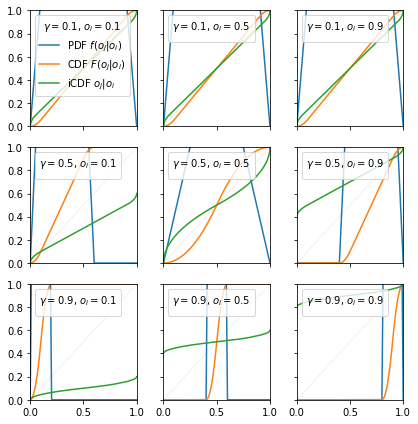

In [15]:
n_samples = 100000
v2 = torch.linspace(0, 1, n_samples).view(-1, 1)

gammas = [0.1, 0.5, 0.9]
v1s = [0.1, 0.5, 0.9]
fig, axs = plt.subplots(
    nrows=len(gammas), ncols=len(v1s),
    sharex=True, sharey=True,
    figsize=(6, 6)
)

for i, gamma in enumerate(gammas):
    for j, v1 in enumerate(v1s):
        ax = axs[i, j]
        pdf = pdf_v2_cond_v1(gamma, v1)(v2)
        cdf = cdf_v2_cond_v1(gamma, v1)(v2)
        icdf = icdf_v2_cond_v1(gamma, torch.tensor([v1]))(v2[v2 <= 1]).squeeze()
        ax.plot([0, 1], [0, 1], color='whitesmoke')
        ax.plot(v2, pdf, label='PDF $f(o_j|o_i)$' if (i,j)==(0,0) else None)
        ax.plot(v2, cdf, label='CDF $F(o_j|o_i)$' if (i,j)==(0,0) else None)
        ax.plot(v2[v2 <= 1], icdf, label='iCDF $o_j|o_i$' if (i,j)==(0,0) else None)
        #ax.hist(icdf_v2_cond_v1(gamma, torch.tensor([v1]))(torch.tensor(np.random.uniform(0, 1, n_samples))),
        #        30, color='lightgrey', density=True)
        ax.set_xlim([0, 1]); ax.set_ylim([0, 1])
        ax.legend(loc='upper left', title='$\gamma={}$, $o_i={}$'
                  .format(gamma, v1))
        #print('volume:', torch.mean(pdf).item() * 2)
plt.tight_layout()
plt.savefig('densities_llg_constant.eps', transparent=True, pad_inches=0.0)
plt.show()